In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
# fix random number to ensore the reliability of our results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
SEED = 47
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(SEED)
device

/home/karinog/miniconda3/envs/ds-study/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [50]:
def newdropout(data, subspace):
    """データのうち一部をゼロに置き換えてしまう。これはスモールデータにおいて過学習を防ぐ方法として知られている。
    Improving neural networks by preventing co-adaptation of feature detectors
    https://arxiv.org/pdf/1207.0580.pdf
    """
    result = np.zeros_like(data)
    shuffled_indices=np.random.permutation(data.shape[1])
    indices =shuffled_indices[:subspace]
    result[:, indices] = data[:, indices]
    return result

# Framework of neural networks
class NN(nn.Module):
    def __init__(self, units, activate, dropout):
        super(NN, self).__init__()
        self.layers = self._make_layer(units, activate,dropout)

    def forward(self, x):
        predict = self.layers(x)
        return predict

    def _make_layer(self, units, activate,dropout):
        layers = []
        for i in range(len(units)-1):
            layers += [nn.Linear(units[i], units[i+1]), nn.BatchNorm1d(units[i+1]), activate, nn.Dropout(p=dropout)]
        layers += [nn.Linear(units[-1], 1)]
        return nn.Sequential(*layers)
    
def evaluate(output1, output2, alpha, Label, loss_function):
    loss1 = loss_function(output1, Label)  # model1の予測と実測の損失関数
#     loss2 = (output1 - output2).pow(2).sum().item()/output1.shape[0]
    loss2 = loss_function(output1, output2)  # model1の予測とmodel2の予測の損失関数
    return loss1, loss2, loss1+alpha*loss2

## データの準備

In [4]:
period = 0
# length of training time points
train_time_points = 30  # ここまでを学習データとする

In [7]:
root = "../dataset/Lorentz/Training"
X = np.loadtxt(f'{root}/Lorentz.txt')
X.shape  # 55サンプル、90次元

(55, 90)

In [98]:
y = np.loadtxt(f'{root}/x.txt')

In [201]:
step = 15
repeat = 5

In [202]:
X_val = X[train_time_points - 2:train_time_points, ]
X_val = torch.tensor(X_val).to(device)

In [203]:
y_tr = y[step:train_time_points].reshape(-1,1)
y_tr = torch.tensor(y_tr, dtype=torch.float64).to(device)

In [204]:
y_tr.shape

torch.Size([15, 1])

In [205]:
X_tr_list = []
for i in range(step):
    # print(step-i-1, train_time_points-i-1)
    X_tr_list.append(X[step-i-1:train_time_points-i-1,:])

In [206]:
final_predicts = np.array([0.0] * step)  # 最終的な予測値の格納先

## モデルの準備

In [222]:
cycle = 3
LR = 0.005
D = 0.9
dropout = 0.0
n_epochs = 300
alpha = 0
w = 0.0001
activate = nn.LeakyReLU(0.7)

In [223]:
input_size = X.shape[1]
units = [input_size]+[500, 200, 150, 50]

In [224]:
loss_function = nn.MSELoss()

In [225]:
repeat

5

In [226]:
eval_index = np.array([1,4,8])

In [227]:
# 以下をrepeatの数だけ繰り返す。

# 予測対象期間だけモデルを用意する

models = [NN(units, activate, dropout).to(device).double() for i in range(step)]
optimizers = [torch.optim.Adam(model.parameters(),lr=LR,weight_decay=w) for model in models]
# for r in range(repeat):
    
for j in range(cycle):
    for modelindex in range(1, step): # 予測対象期間について順々に学習
        print(r, j, modelindex)
        models[modelindex].train()
        for epoch in range(n_epochs):
            X_tr1 = torch.tensor(newdropout(X_tr_list[modelindex], int(input_size*D)), dtype=torch.float64).to(device)
            output1 = models[modelindex](X_tr1)
            loss1 = loss_function(output1, y_tr)

            models[0].eval()
            X_tr0 = torch.tensor(newdropout(X_tr_list[0], int(input_size*D)), dtype=torch.float64).to(device)
            output2 = models[0](X_tr0)
            for premodelindex in range(1,modelindex):
                models[premodelindex].eval()
                X_trp = torch.tensor(newdropout(X_tr_list[premodelindex], int(input_size*D)), dtype=torch.float64).to(device)
                output2 += models[premodelindex](X_trp)
            output2 /= modelindex
            loss2 = loss_function(output1, output2)
            loss = loss1 + alpha*loss2
            # print(loss)
            optimizers[modelindex].zero_grad()
            loss.backward()
            optimizers[modelindex].step()
        models[modelindex].eval()

    models[0].train()
    for epoch in range(n_epochs):
        X_tr0 = torch.tensor(newdropout(X_tr_list[0], int(input_size*D)), dtype=torch.float64).to(device)
        output1 = models[0](X_tr0)
        loss1 = loss_function(output1, y_tr)

        models[1].eval()
        X_tr1 = torch.tensor(newdropout(X_tr_list[1], int(input_size*D)), dtype=torch.float64).to(device)
        output2 = models[1](X_tr1)
        for aftermodelindex in range(2,step):
            models[aftermodelindex].eval()
            X_tra = torch.tensor(newdropout(X_tr_list[aftermodelindex], int(input_size*D)), dtype=torch.float64).to(device)
            output2 += models[aftermodelindex](X_tra)
        output2 /= (step-1)
        loss2 = loss_function(output1, output2)
        loss = loss1 + alpha*loss2
        optimizers[0].zero_grad()
        loss.backward()
        optimizers[0].step()
    models[0].eval()

preds = np.array([model(X_val[1:2,:])[0].item() for model in models])
mae = np.abs(preds - y[train_time_points:train_time_points+step]).mean()
print(mae)
# final_predicts += preds
# final_predicts /= repeat

4 0 1
4 0 2
4 0 3
4 0 4
4 0 5
4 0 6
4 0 7
4 0 8
4 0 9
4 0 10
4 0 11
4 0 12
4 0 13
4 0 14
4 1 1
4 1 2
4 1 3
4 1 4
4 1 5
4 1 6
4 1 7
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 2 1
4 2 2
4 2 3
4 2 4
4 2 5
4 2 6
4 2 7
4 2 8
4 2 9
4 2 10
4 2 11
4 2 12
4 2 13
4 2 14
5.6200274783055555


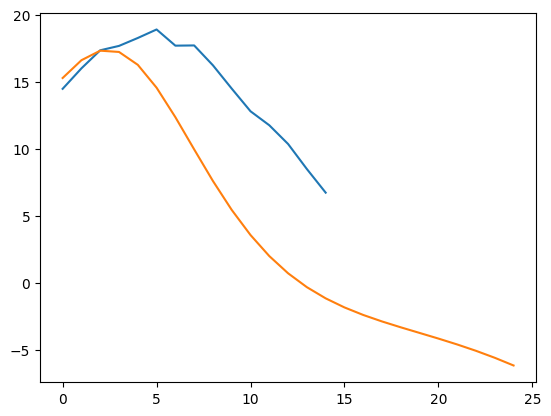

In [228]:
plt.plot(preds)
plt.plot(y[train_time_points:])

In [8]:
X_tr1 = X[1:train_time_points-1,:]  # t1 ~ t28
X_tr2 = X[0:train_time_points-2,:]  # t0 ~ t27
X_tr1_trc = torch.tensor(train1,dtype=torch.float64)
X_tr2_trc = torch.tensor(train2,dtype=torch.float64)
INPUT_SIZE = X_tr1.shape[1]


array([[ 4.30532237,  2.98566922, 23.70626533, ..., -6.32701819,
        -2.13357258, 30.06205446],
       [ 4.15044866,  3.32593112, 22.7349345 , ..., -5.48570843,
        -1.92695022, 28.73346745],
       [ 4.08841884,  3.72548179, 21.83707314, ..., -4.76907114,
        -1.87950821, 27.43083272],
       ...,
       [12.98255029, 15.16906991, 30.18761236, ..., -3.18655783,
        -5.56765015, 13.70211602],
       [13.30363694, 14.00537627, 32.37058175, ..., -3.65253484,
        -6.43447018, 13.39004451],
       [13.30468528, 12.33523865, 34.11427435, ..., -4.20697861,
        -7.44863723, 13.22554475]])

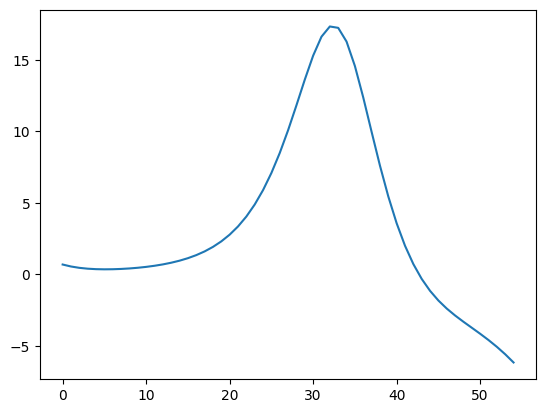

In [123]:
train1 = data[1:train_time_points-1,:]  # t1 ~ t28
train2 = data[0:train_time_points-2,:]  # t0 ~ t27
Train1 = torch.tensor(train1,dtype=torch.float64)
Train2 = torch.tensor(train2,dtype=torch.float64)
INPUT_SIZE = train1.shape[1]
Label = np.loadtxt(f'{root}/x.txt')
plt.plot(Label)

In [124]:
Pred = data[train_time_points - 2:train_time_points, ]
Pred = torch.tensor(Pred).to(device)
Pred.shape

torch.Size([2, 90])

In [125]:
INPUT_SIZE

90

In [126]:
units = [INPUT_SIZE]+[500, 200, 150, 50]
net = NN(units)
print(net)

NN(
  (layers): Sequential(
    (0): Linear(in_features=90, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=200, out_features=150, bias=True)
    (9): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=150, out_features=50, bias=True)
    (13): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=50, out_features

In [127]:
len(label), train1.shape

(28, (28, 90))

In [128]:
steps = 5
repeating = 5

final_predicts = np.array([0.0]*steps)
for j in range(repeating):  # 乱数
    label = Label[2+period:train_time_points+period,]
    label = list(label)
    targets = []
    predicts = []
    errors = []
    for index in range(steps): # stepでどこまで
        print(j,index)
        LABEL = np.array(label).reshape(train_time_points - 2, 1)
        LABEL = torch.tensor(LABEL, dtype=torch.float64).to(device)
        
        # 1個目のモデル定義
        model1 = NN(units)
        model1 = model1.to(device)
        optimizer1 = torch.optim.Adam(model1.parameters(),
                                      lr=LR1,
                                      weight_decay=w)
        # 2個目のモデル定義
        model2 = NN(units)
        model2 = model2.to(device)
        optimizer2 = torch.optim.Adam(model2.parameters(),
                                      lr=LR2,
                                      weight_decay=w)
        loss_function = nn.MSELoss()
        
        # 学習
        model1 = model1.double()
        model2 = model2.double()
        
        modelpreds = []
        for epoch in range(EPOCH):
            model1.train()
            model2.train()
            train1_dropout_data = torch.tensor(newdropout(Train1.numpy(), int(INPUT_SIZE*D)),dtype=torch.float64)
            train2_dropout_data = torch.tensor(newdropout(Train2.numpy(), int(INPUT_SIZE*D)),dtype=torch.float64)
            
            train1_dropout_data = train1_dropout_data.to(device)
            train2_dropout_data = train2_dropout_data.to(device)
            output1 = model1(train1_dropout_data)
            output2 = model2(train2_dropout_data)
            # loss function
            loss11, loss12, loss1 = evaluate(output1, output2, alpha, LABEL, loss_function)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()
            output1 = model1(train1_dropout_data)
            output2 = model2(train2_dropout_data)
            loss21, loss22, loss2 = evaluate(output2, output1, alpha, LABEL, loss_function)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()
            
            # if epoch % 10 == 0:
            #     print(f"epoch : {epoch}, loss1 : {loss1}, loss2 : {loss2}")
            
            model1.eval()
            model2.eval()
            pred1 = model1(Pred)
            pred2 = model2(Pred)
            modelpreds.append((pred1[1].item() + pred2[0].item()) / 2.0)
            
        target = Label[train_time_points + index + period]
        targets.append(target)
        predicts.append(modelpreds[-1])
        
    predicts, target = np.array(predicts), np.array(targets)
    final_predicts += predicts
final_predicts /= repeating


0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [130]:
targets, final_predicts

([15.28224219752453,
  16.608352466636138,
  17.320396937826036,
  17.22474627115457,
  16.265122945410646],
 array([16.41887673, 16.26658327, 16.23041114, 16.14579464, 16.16615155]))

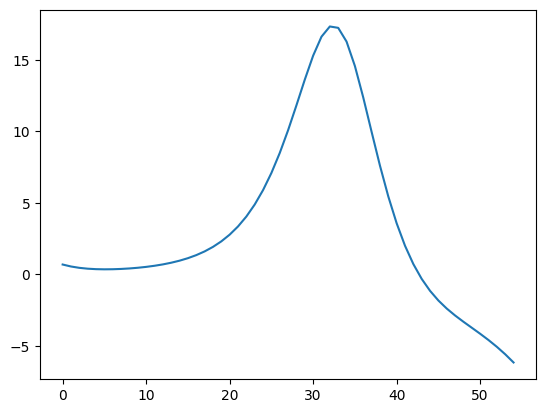

In [102]:
plt.plot(Label)

## 2期以上先まで予測する場合

In [166]:
step = 2
repeat = 10
NEWINPUTS = []
for i in range(step):
    NEWINPUTS.append(data[step-i-1:train_time_points-i-1,:])

In [167]:
NEWLABELS = Label[step:train_time_points].reshape(-1,1)
NEWLABELS = torch.tensor(NEWLABELS, dtype=torch.float64).to(device)
def alldropout(data, subspace):
    result = [np.zeros_like(d) for d in data]
    shuffled_indices=np.random.permutation(data[0].shape[1])
    indices =shuffled_indices[:subspace]
    for i in range(len(result)):
        result[i][:, indices] = data[i][:, indices]
    return result


In [169]:
cycle = 3
EPOCH = 5
D = 0.5
DROPOUT = 0.5
alpha=1
LR = 1e-3
w = 0

final_predicts = np.array([0.0] * step)

loss_function = nn.MSELoss()

for r in range(repeat):
    MODELS = [NN(units).to(device).double() for i in range(step)]
    for i in range(step):
        saved_parametes = torch.load('./models/'+str(r)+'_'+str(i)+'.pt')
        MODELS[i].load_state_dict(saved_parametes)
        optimizers = [torch.optim.Adam(model.parameters(),lr=LR,weight_decay=w) for model in MODELS]
    final_predicts = final_predicts + mini_train(cycle, EPOCH, D, alpha, MODELS, optimizers, loss_function)
final_predicts /= repeat
targets = Label[train_time_points:train_time_points+step]
targets

NameError: name 'mini_train' is not defined